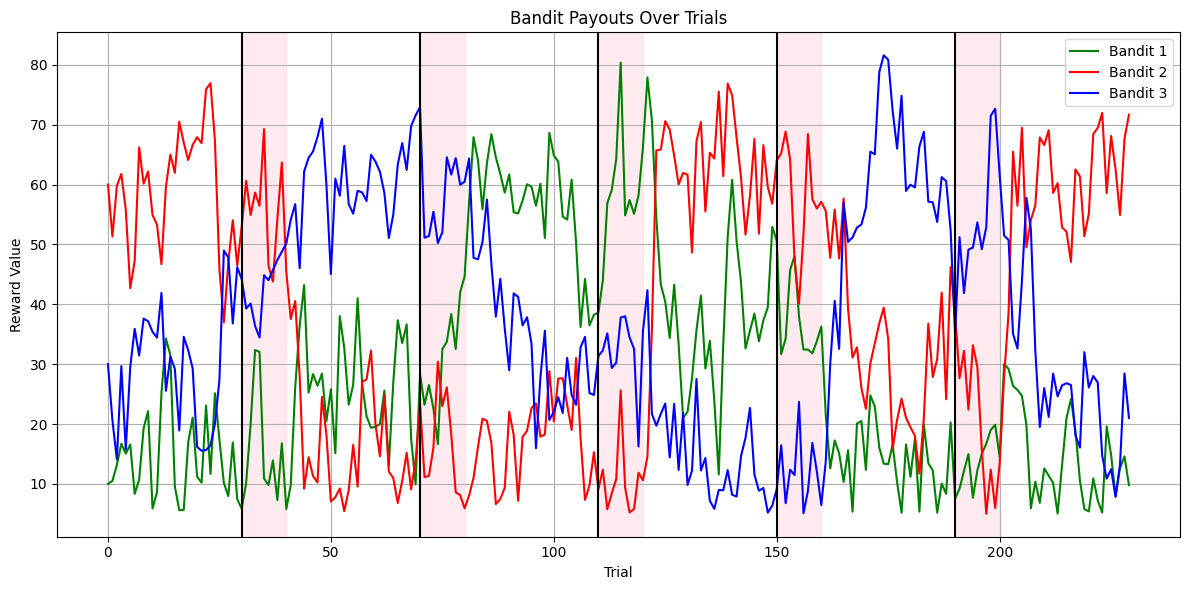

{1: array([0.1       , 0.10504111, 0.1315929 , 0.16715365, 0.15073152,
        0.1659368 , 0.0834711 , 0.1072482 , 0.19303891, 0.2214963 ,
        0.05905438, 0.08613201, 0.25145792, 0.34284191, 0.31518252,
        0.09568424, 0.05616774, 0.05674006, 0.16953619, 0.21083001,
        0.11193442, 0.10220618, 0.23103528, 0.1167374 , 0.25147857,
        0.17412744, 0.10147986, 0.07971539, 0.16933837, 0.07431956,
        0.05860757, 0.10188272, 0.19962882, 0.32368957, 0.32040948,
        0.10933262, 0.09813074, 0.13934962, 0.07303174, 0.16801037,
        0.05810703, 0.09811584, 0.26132702, 0.36468852, 0.43215499,
        0.2526709 , 0.28335824, 0.26401042, 0.28429824, 0.20507308,
        0.25808569, 0.1511813 , 0.38027031, 0.32718667, 0.23238806,
        0.26534017, 0.41022142, 0.26853214, 0.21310008, 0.19380752,
        0.19546436, 0.19998001, 0.25593685, 0.13128195, 0.26954478,
        0.37336907, 0.33530165, 0.36646518, 0.17591815, 0.09915032,
        0.28314259, 0.23220108, 0.26514137, 0

In [10]:
import numpy as np

# ----- Constants -----
num_bandits = 3
block_len = 40
num_blocks = 6
num_trials = block_len * num_blocks * 2
init_payoff = [10, 60, 30]
decayTheta = init_payoff.copy()
payoff_bounds = [5, 95]
decay_lambda = 0.6
drift_noise = 8

rotation_trials = [40, 80, 120, 160, 200, 240, 280, 320, 360, 400, 440]
deterministic_trials = [30, 70, 110, 150, 190]

# Add bumped deterministic trials
ctx_bump = 2
for i in range(len(deterministic_trials)):
    for j in range(1, ctx_bump):
        trial_to_add = deterministic_trials[i] + j
        deterministic_trials.append(trial_to_add)

# ----- Functions -----
def normal_random():
    return np.random.normal(loc=0, scale=1)

def mean(x):
    return sum(x) / len(x)

def rotate_decayTheta(current_decayTheta):
    bestOpt = np.argmax(current_decayTheta)
    shuffled = current_decayTheta.copy()
    while np.argmax(shuffled) == bestOpt:
        np.random.shuffle(shuffled)
    return list(shuffled)

# ----- Initialize payout matrix -----
payout = np.zeros((num_bandits, num_trials))
for i in range(num_bandits):
    payout[i][0] = init_payoff[i]

# ----- Main drift loop -----
for trial_idx in range(num_trials):

    # ROTATION TRIALS: Change which bandit has the highest expected payoff
    if trial_idx in rotation_trials:
        decayTheta = rotate_decayTheta(decayTheta)

    # DETERMINISTIC TRIALS: Force the best bandit's value to 100
    if trial_idx in deterministic_trials:
        bestOpt = np.argmax(decayTheta)
        payout[bestOpt][trial_idx] = 100

    # DRIFT: Smooth payoff change from previous value
    if trial_idx > 0:
        decay_lambda_eff = 0.95 if trial_idx % block_len < 2 else decay_lambda

        for bandit in range(num_bandits):
            prev = payout[bandit][trial_idx - 1]
            theta = decayTheta[bandit]
            noise = normal_random() * drift_noise

            drifted = decay_lambda_eff * prev + (1 - decay_lambda_eff) * theta + noise

            # Reflect at bounds
            if drifted > payoff_bounds[1]:
                drifted = payoff_bounds[1] - (drifted - payoff_bounds[1])
            elif drifted < payoff_bounds[0]:
                drifted = payoff_bounds[0] + (payoff_bounds[0] - drifted)

            payout[bandit][trial_idx] = drifted

# Convert to list of lists if needed
payout_list = payout.tolist()

import matplotlib.pyplot as plt

# Assume `payout` is a 2D list or NumPy array: shape (3, num_trials)
# If you haven't already defined `payout`, run the generation code first.



probabilities = {
    1: payout[0] * 0.01,
    2: payout[1] * 0.01,
    3: payout[2] * 0.01
}
# Plotting
plt.figure(figsize=(12, 6))

# Plot each bandit's payout trajectory
plt.plot(payout[0][0:230], label='Bandit 1', color='green')
plt.plot(payout[1][0:230], label='Bandit 2', color='red')
plt.plot(payout[2][0:230], label='Bandit 3', color='blue')
for d in [30, 70, 110, 150, 190]:
    plt.axvspan(d,d+10, color='pink', alpha=0.3)
    plt.axvline(d,color='black')
# Formatting
plt.xlabel('Trial')
plt.ylabel('Reward Value')
plt.title('Bandit Payouts Over Trials')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()
probabilities

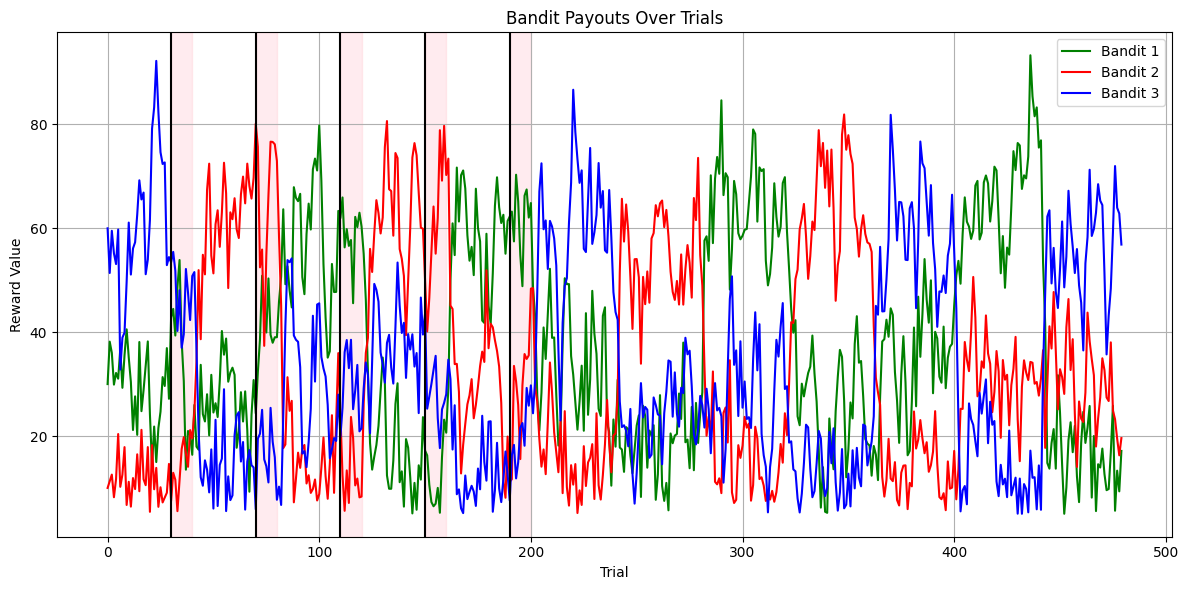

In [212]:
# Plotting
plt.figure(figsize=(12, 6))

# Plot each bandit's payout trajectory
plt.plot(payout[0][0:], label='Bandit 1', color='green')
plt.plot(payout[1][0:], label='Bandit 2', color='red')
plt.plot(payout[2][0:], label='Bandit 3', color='blue')
for d in [30, 70, 110, 150, 190]:
    plt.axvspan(d,d+10, color='pink', alpha=0.3)
    plt.axvline(d,color='black')
# Formatting
plt.xlabel('Trial')
plt.ylabel('Reward Value')
plt.title('Bandit Payouts Over Trials')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

In [215]:
import pandas as pd

df = pd.DataFrame(probabilities)

# Optional: Rename columns if needed
df.columns = [f'Bandit_{i}' for i in df.columns]
# Assuming df already exists
# Define the scaling values by rank: 0 = highest
scale = {0: 0.6, 1: 0.3, 2: 0.1}

# Function to map each value in the row to its scaled reward
def rank_and_scale(row):
    ranks = row.rank(ascending=False, method='first') - 1  # 0 = highest, 2 = lowest
    return row.rank(ascending=False, method='first').sub(1).map(scale)

# Apply to each row
scaled_df = df[['Bandit_1', 'Bandit_2', 'Bandit_3']].apply(rank_and_scale, axis=1)

# Rename columns
scaled_df.columns = ['Bandit_1_scaled', 'Bandit_2_scaled', 'Bandit_3_scaled']

# Concatenate with original df
df = pd.concat([df, scaled_df], axis=1)
# Save to CSV
df.to_csv('/Users/rohinpalsule/Desktop/scaledpayout7.csv',index=False)

In [11]:
# Load the CSV file
import pandas as pd
payoutNum = np.random.randint(1,8)
df = pd.read_csv(f'../run_exp/static/good_payouts/scaledpayout{payoutNum}.csv')  # Replace with your actual path

# Convert to probability dict
probabilities = {
    1: df['Bandit_1'].to_numpy(),
    2: df['Bandit_2'].to_numpy(),
    3: df['Bandit_3'].to_numpy()
}

# Not needed but in case needed
payout = {
    1: probabilities[1] / 0.01,
    2: probabilities[2] / 0.01,
    3: probabilities[3] / 0.01
}
probabilities

{1: array([0.6       , 0.60475806, 0.6187968 , 0.577138  , 0.59658142,
        0.6466102 , 0.5970205 , 0.60766382, 0.47809742, 0.45206773,
        0.68345359, 0.61991596, 0.71796632, 0.66381684, 0.60028107,
        0.64029755, 0.62895953, 0.51200815, 0.60934987, 0.51129807,
        0.45755564, 0.54166926, 0.55311996, 0.58426269, 0.65353193,
        0.60615251, 0.68234109, 0.83563917, 0.65480225, 0.50621887,
        0.53134887, 0.4795085 , 0.46359417, 0.54739256, 0.60587821,
        0.58598843, 0.57652524, 0.53551721, 0.52544447, 0.41220258,
        0.38044662, 0.26164619, 0.19008968, 0.16793809, 0.25015882,
        0.06418172, 0.07853087, 0.06914005, 0.12459837, 0.23453641,
        0.15372798, 0.15900098, 0.22012305, 0.21969812, 0.19509415,
        0.07017905, 0.12122349, 0.06412346, 0.14162106, 0.06515419,
        0.13139719, 0.06890526, 0.19138009, 0.22631097, 0.09406213,
        0.05608734, 0.05821319, 0.09223339, 0.08841468, 0.08898676,
        0.11454673, 0.12842198, 0.08880023, 0

In [17]:
image_prefix = "../run_exp/static/"
# Valid probes (seen in task) and Invalid (foils during memory phase)
valid_probe_images = []
invalid_probe_images = []
for i in range(1,231): # 230 trials (30 trials first block + 40 trials * 5 other blocks)
    if i < 10:   
        valid_probe_images.append(image_prefix + f"probes/probes-0{i}.png")
    else:
        valid_probe_images.append(image_prefix + f"probes/probes-{i}.png")
for i in range(231,256): # 25 trials (wrong probe trials during testing)
    invalid_probe_images.append(image_prefix + f"probes/probes-{i}.png")
contexts = [image_prefix + "contexts/context_coral_beach.png",
            image_prefix + "contexts/context_sunleaf_forest.png",
            image_prefix + "contexts/context_icecap_mountain.png",
            image_prefix + "contexts/context_driftwood_beach.png",
            image_prefix + "contexts/context_stonepine_forest.png",
            image_prefix + "contexts/context_greenrock_mountain.png"]
first_block = 30

# Init main phase image stacks
stacked_all_pirates = []
stacked_red_remember = []
stacked_red_reward = []
stacked_white_remember = []
stacked_white_reward = []
stacked_black_remember = []
stacked_black_reward = []
context_labels = []
stacked_planet_welcome = []
stacked_red_pirate = []
stacked_white_pirate = []
stacked_black_pirate = []
stacked_island_bye = []
stacked_island_nopirate = []
block_len_adjusted = 70
early_block = 30
for context_idx,context in enumerate(contexts):
    if context_idx == 0: # First context is 30 trials
        for trial_idx in range(first_block):
            stacked_red_remember.append([context,valid_probe_images[trial_idx]])
            stacked_red_reward.append([context,valid_probe_images[trial_idx]])
            context_labels.append(context.split("contexts/context_")[-1].split(".png")[0])
    else:
        for trial_idx in range(early_block,block_len_adjusted): # Rest of the contexts are 40 trials
            stacked_red_remember.append([context,valid_probe_images[trial_idx]])
            context_labels.append(context.split("contexts/context_")[-1].split(".png")[0])
        block_len_adjusted += 40
        early_block +=40
    print(context)



../run_exp/static/contexts/context_coral_beach.png
../run_exp/static/contexts/context_sunleaf_forest.png
../run_exp/static/contexts/context_icecap_mountain.png
../run_exp/static/contexts/context_driftwood_beach.png
../run_exp/static/contexts/context_stonepine_forest.png
../run_exp/static/contexts/context_greenrock_mountain.png
